# Modelling

## Import

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras import models, layers, losses, optimizers, metrics, callbacks

import matplotlib.pyplot as plt

from keras_preprocessing.image import ImageDataGenerator

%run ../scripts/save_utils.py

## Baseline model

## Data Load

In [2]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data('../save_files/processed_data.pkl')

In [3]:
df_train = pd.DataFrame({'image_path':x_train, 'label':y_train})
df_val = pd.DataFrame({'image_path':x_val, 'label':y_val})
df_test = pd.DataFrame({'image_path':x_test, 'label':y_test})

## ImageDataGenerator

Let's initialize data generators. Most importantly, they will rescale vectorized images such that the values are going to be in range 0-1.

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Now we need to specify the directories in which these images reside. I have decided to keep original resolution of 512x512 pixels. The *batch_size* is relatively small to reduce memory usage.

In [5]:
train_generator = train_datagen.flow_from_dataframe(df_train, '..\\data\\raw\\merged_data\\',
                                                    x_col='image_path', y_col='label',
                                                    target_size=(512, 512), batch_size=8,
                                                    class_mode='categorical', validate_filenames=False)

validation_generator = val_datagen.flow_from_dataframe(df_val, '..\\data\\raw\\merged_data\\',
                                                       x_col='image_path', y_col='label',
                                                       target_size=(512, 512), batch_size=8,
                                                       class_mode='categorical', validate_filenames=False)

test_generator = test_datagen.flow_from_dataframe(df_test, '..\\data\\raw\\merged_data\\',
                                                  x_col='image_path', y_col='label',
                                                  target_size=(512, 512), batch_size=8,
                                                  class_mode='categorical', validate_filenames=False)

Found 4213 non-validated image filenames belonging to 4 classes.
Found 1405 non-validated image filenames belonging to 4 classes.
Found 1405 non-validated image filenames belonging to 4 classes.


Now we initialize a baseline model. Notice that I have used *clear_session* to reset all variables that model might save before each use of the model (i.e. when re-running notebook).

In [6]:
tf.keras.backend.clear_session()

baseline_model = models.Sequential()
baseline_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(512, 512, 3)))
baseline_model.add(layers.MaxPooling2D(2, 2))
baseline_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
baseline_model.add(layers.MaxPooling2D(2, 2))
baseline_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
baseline_model.add(layers.MaxPooling2D(2, 2))
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(256, activation='relu'))
baseline_model.add(layers.Dense(4, activation='softmax'))

In [7]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 128)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

In [8]:
baseline_model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.Recall()])

We will also make a callback to invoke early stop. It will monitor validation loss, since we want to minimize it as much as possible.

In [9]:
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=8)

We set *steps_per_epoch* to 500 since *batch_size* is set to 8 and we have approx. 4000 samples in the training set. Thus, to cover as much train data as possible, we will need 500 batches of 8 images.

In [10]:
baseline_history_train = baseline_model.fit(train_generator, steps_per_epoch=500, epochs=30, validation_data=validation_generator, validation_steps=50, callbacks=[stop_early], verbose=1)

Epoch 1/30
500/500 [==============================] - 69s 121ms/step - loss: 0.6408 - recall: 0.7223 - val_loss: 0.4399 - val_recall: 0.8125
Epoch 2/30
500/500 [==============================] - 57s 113ms/step - loss: 0.2502 - recall: 0.9072 - val_loss: 0.3010 - val_recall: 0.8625
Epoch 3/30
500/500 [==============================] - 56s 112ms/step - loss: 0.1211 - recall: 0.9535 - val_loss: 0.2386 - val_recall: 0.9200
Epoch 4/30
500/500 [==============================] - 56s 112ms/step - loss: 0.0719 - recall: 0.9720 - val_loss: 0.4281 - val_recall: 0.9175
Epoch 5/30
500/500 [==============================] - 56s 112ms/step - loss: 0.0588 - recall: 0.9822 - val_loss: 0.6165 - val_recall: 0.8875
Epoch 6/30
500/500 [==============================] - 56s 112ms/step - loss: 0.0360 - recall: 0.9915 - val_loss: 0.2945 - val_recall: 0.9300
Epoch 7/30
500/500 [==============================] - 56s 112ms/step - loss: 0.0462 - recall: 0.9882 - val_loss: 0.5621 - val_recall: 0.8700
Epoch 8/30
50

It is a good practise to save a model after training to be able to use it whenever we want without the need to retrain it if for some reason we would have lost its parameters.

In [11]:
baseline_model.save('..\\save_files\\baseline.h5')

And now we evaluate the model on **test** data:

In [12]:
baseline_history_test = baseline_model.evaluate(test_generator, batch_size=32, return_dict=True)

176/176 [==============================] - 8s 42ms/step - loss: 0.5377 - recall: 0.9310


In [13]:
print('test loss:   ', baseline_history_test['loss'])
print('test recall: ', baseline_history_test['recall'])

test loss:    0.5377232432365417
test recall:  0.9309608340263367


We got very good results even for the baseline model.  
  
Let's now visualize its training and evaluation process to see how it behaves.

## Baseline training and validation visualization

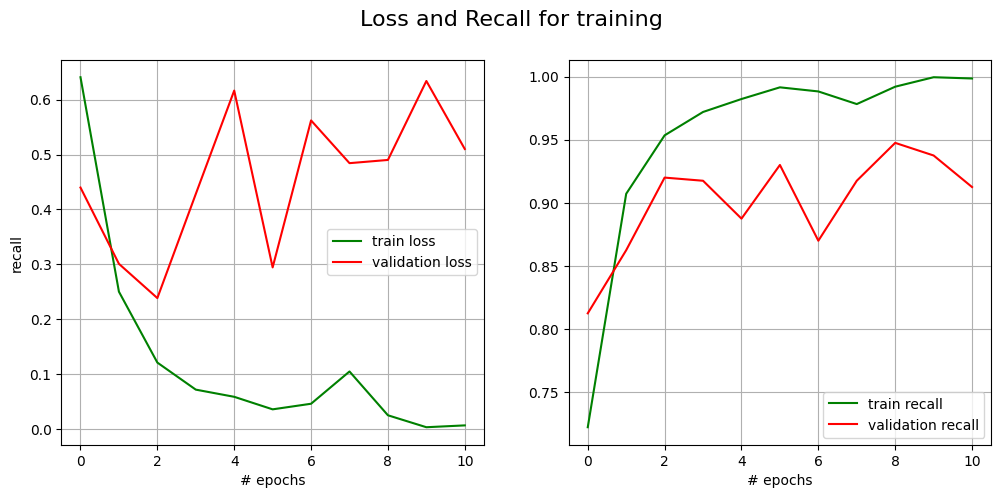

In [15]:
train_results = baseline_history_train.history
num_epochs = np.arange(len(train_results['loss']))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(num_epochs, train_results['loss'], label='train loss', color='green')
axes[0].plot(num_epochs, train_results['val_loss'], label='validation loss', color='red')
axes[0].set_ylabel('loss')
axes[0].legend()
axes[0].grid()

axes[1].plot(num_epochs, train_results['recall'], label='train recall', color='green')
axes[1].plot(num_epochs, train_results['val_recall'], label='validation recall', color='red')
axes[0].set_ylabel('recall')
axes[1].legend()
axes[1].grid()

for ax in axes:
    ax.set_xlabel('# epochs')

fig.suptitle('Loss and Recall for training', fontsize=16);